# Parallel Programming

The goal is to design parallel programs that are flexible, efficient and simple.

**Step 0**: Start by profiling a serial program to identify bottlenecks

**Step 1**: Are there for opportunities for parallelism?

- Can tasks be performed in parallel?
    - Function calls
    - Loops
- Can data be split and operated on in parallel?
    - Decomposition of arrays along rows, columns, blocks
    - Decomposition of trees into sub-trees
- Is there a pipeline with a sequence of stages?
    - Data preprocessing and analysis
    - Graphics rendering

**Step 2**: What is the nature of the parallelism?

- Linear
    - Embarrassingly parallel programs
- Recursive
    - Adaptive partitioning methods

**Step 3**: What is the granularity?

- 10s of jobs
- 1000s of jobs

**Step 4**: Choose an algorithm

- Organize by tasks
    - Task parallelism
    - Divide and conquer

- Organize by data
    - Geometric decomposition
    - Recursive decomposition

- Organize by flow
    - Pipeline
    - Event-based processing

**Step 5**: Map to program and data structures

- Program structures
    - Single program multiple data (SPMD)
    - Master/worker
    - Loop parallelism
    - Fork/join
- Data structures 
    - Shared data
    - Shared queue
    - Distributed array

**Step 6**: Map to parallel environment

- Multi-core shared memory
    - Cython with OpenMP
    - multiprocessing
    - IPython.cluster
- Multi-computer
    - IPython.cluster
    - MPI
    - Hadoop / Spark
- GPU
    - CUDA
    - OpenCL

**Step 7**: Execute, debug, tune in parallel environment

## Embarrassingly parallel programs

Many statistical problems are embarrassingly parallel and can be easily decomposed into independent tasks or data sets. Here are several examples:

- Monte Carlo integration
- Multiple chains of MCMC
- Bootstrap for confidence intervals
- Power calculations by simulation
- Permutation-resampling tests 
- Fitting same model on multiple data sets

Other problems are serial at small scale, but can be parallelized at large scales. For example, EM and MCMC iterations are inherently serial since there is a dependence on the previous state, but within a single iteration, there can be many thousands of density calculations (one for each data point to calculate the likelihood), and this is an embarrassingly parallel problem within a single iteration. 

These "low hanging fruits" are great because they offer a path to easy parallelism with minimal complexity.

## Degree of parallelism

**The bigger the problem, the more scope there is for parallelism**

**Amhdahls' law** says that the speedup from parallelization is bounded by the ratio of parallelizable to irreducibly serial code in the algorithm. However, for big data analysis, **Gustafson's Law** is more relevant. This says that we are nearly always interested in increasing the size of the parallelizable bits, and the ratio of parallelizable to irreducibly serial code is not a static quantity but depends on data size. For example, Gibbs sampling has an irreducibly serial nature, but for large samples, each iteration may be able perform PDF evaluations in parallel for zillions of data points.

In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Python version

In [2]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

Note that we use a 16-fold smaller image for the Python version.

CPU times: user 4.74 s, sys: 5.2 ms, total: 4.75 s
Wall time: 4.75 s


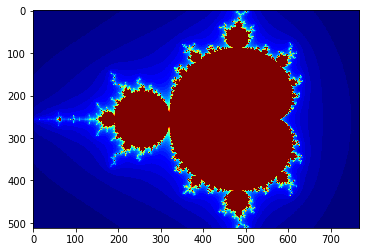

In [4]:
%%time

h, w = 2048//4, 3072//4
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism with `multiprocessing`

In [13]:
import multiprocessing

In [31]:
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    args = []    
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            args.append((real, imag, iters))
            
    p = multiprocessing.Pool()
    colors = np.array(p.starmap(mandel, args), 'float')
    p.close()
    
    return colors.reshape((width, height)).T

CPU times: user 1.88 s, sys: 160 ms, total: 2.04 s
Wall time: 2.03 s


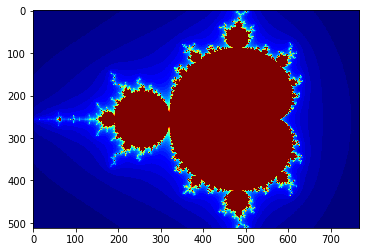

In [32]:
%%time

h, w = 2048//4, 3072//4
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
gimage = create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism in `numba`

In [2]:
from numba import jit, prange

### JIT with `numba`

In [5]:
@jit(nopython=True, cache=True)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

In [6]:
@jit(nopython=True, cache=True)
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

CPU times: user 1.17 s, sys: 14.3 ms, total: 1.19 s
Wall time: 1.19 s


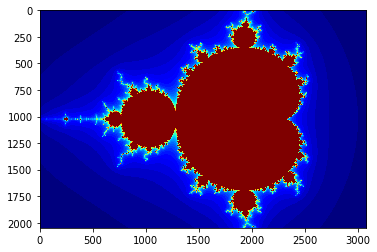

In [7]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

### JIT with `numba` and `prange` using `parallel` option

In [8]:
# function to be run in parallel needs `nogil=True`
@jit(nopython=True, nogil=True)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if abs(z) >= 4:
            return i
    return max_iters

@jit(nopython=True, parallel=True)
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    # replace `range` with `prange`
    for x in prange(width):
        real = xmin + x*pixel_size_x
        for y in prange(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

CPU times: user 2.06 s, sys: 16.5 ms, total: 2.08 s
Wall time: 854 ms


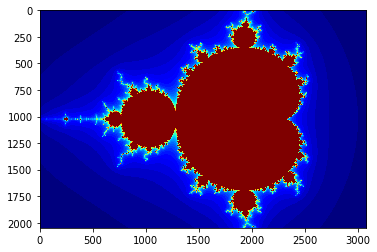

In [9]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

## Parallelism in `cython`

In [3]:
import cython

In [4]:
%load_ext cython

In [5]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

cdef unsigned char mandel_cython(double x, double y, int max_iters):
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(double xmin, double xmax, double ymin, double ymax, 
                          unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color  

CPU times: user 1.26 s, sys: 10.7 ms, total: 1.27 s
Wall time: 1.26 s


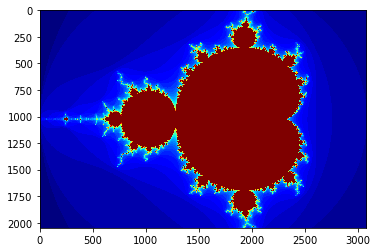

In [6]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass

### Parallel version with `cython`

In [11]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

# All cdef functions need to be `nogil`
cdef extern from "complex.h" nogil:
    double cabs(double complex)

# All cdef functions need to be `nogil`
cdef unsigned char mandel_cython(double x, double y, int max_iters) nogil:
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def create_fractal_cython_par(double xmin, double xmax, double ymin, double ymax, 
                              unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
    
    # use prange in parallel, nogil context
    with cython.nogil, parallel():
        for x in prange(width):
            real = xmin + x*pixel_size_x
            for y in prange(height):
                imag = ymin + y*pixel_size_y
                color = mandel_cython(real, imag, iters)
                image[y, x]  = color  

CPU times: user 3.1 s, sys: 3.6 ms, total: 3.1 s
Wall time: 298 ms


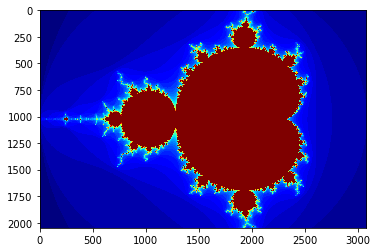

In [12]:
%%time

h, w = 2048, 3072
gimage = np.zeros((h, w), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50
create_fractal_cython_par(xmin, xmax, ymin, ymax, gimage, iters)
plt.imshow(gimage, cmap='jet')
pass